In [265]:
import warnings
warnings.filterwarnings("ignore")

In [266]:
import os
import os.path as op
import sys
sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive
from ind_setup.core import fontsize

import pandas as pd
import numpy as np
import geopandas as gpd

In [197]:
#Area of interest
lon_range  = [129.4088, 137.0541]
lat_range = [1.5214, 11.6587]

In [201]:
shp_f = op.join(os.getcwd(), '..', '..','..', 'data/Palau_EEZ/pw_eez_pol_april2022.shp')
shp_eez = gpd.read_file(shp_f)

https://oceanwatch.pifsc.noaa.gov/

DATASET: https://oceanwatch.pifsc.noaa.gov/erddap/info/md50_exp/index.html


In [13]:
base_url = 'https://oceanwatch.pifsc.noaa.gov/erddap/griddap/md50_exp.csv'
dataset_id = 'MD50'
date_ini = '1998-01-01T00:00:00Z'
date_end = '2023-12-01T00:00:00Z'

url = f'{base_url}?{dataset_id}%5B({date_ini}):1:({date_end})%5D%5B({lat_range[0]}):1:({lat_range[1]})%5D%5B({lon_range[0]}):1:({lon_range[1]})%5D'

In [195]:
data = pd.read_csv(url).iloc[1:].reset_index(drop=True)
data['time'] = pd.to_datetime(data['time'].values)

for var in ['latitude', 'longitude', 'MD50']: data[var] = data[var].astype(float)

/var/folders/88/z9xxhn052qddjc_ppp2j_8gr0000gn/T/ipykernel_10453/1962896482.py:1: DtypeWarning:

Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.



In [151]:
data_xr = data.set_index(['latitude', 'longitude', 'time']).to_xarray()
data_xr['time'] = pd.to_datetime(data_xr.time)
data_xr = data_xr.coarsen(longitude=2, latitude=2).mean()

In [154]:
time = np.where(data_xr.time.dt.year==1999)[0]

In [316]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

def plot_map(shp_eez=None, ax=None, figsize=[10, 6]):
    # Create a new figure and axis

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})

    # Set the extent of the map
    ax.coastlines(resolution='10m')
    ax.gridlines(draw_labels=True)

    if shp_eez is not None:
        shp_eez.boundary.plot(ax=ax, color='grey', linewidth=1.5)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    return ax


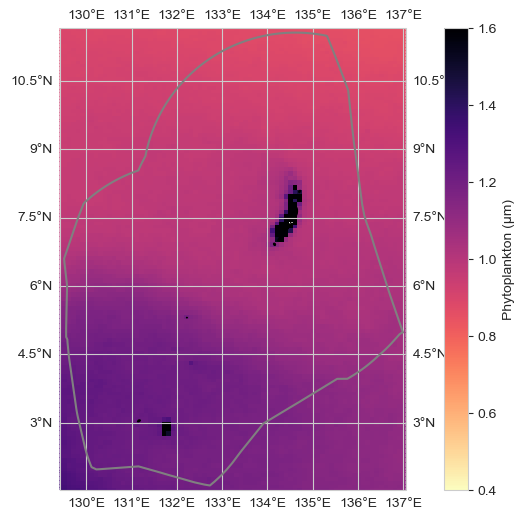

In [320]:

ax = plot_map(shp_eez = shp_eez, figsize = [10, 6])
im = ax.pcolor(data_xr.longitude, data_xr.latitude, data_xr.mean(dim='time').MD50, transform=ccrs.PlateCarree(), 
                cmap = 'magma_r', vmin = 0.4, vmax = 1.6)
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
plt.colorbar(im, ax=ax, label='Phytoplankton (µm)')


In [322]:
data_y = data_xr.resample(time='1YE').mean()
data_an = data_y - data_xr.mean(dim='time')

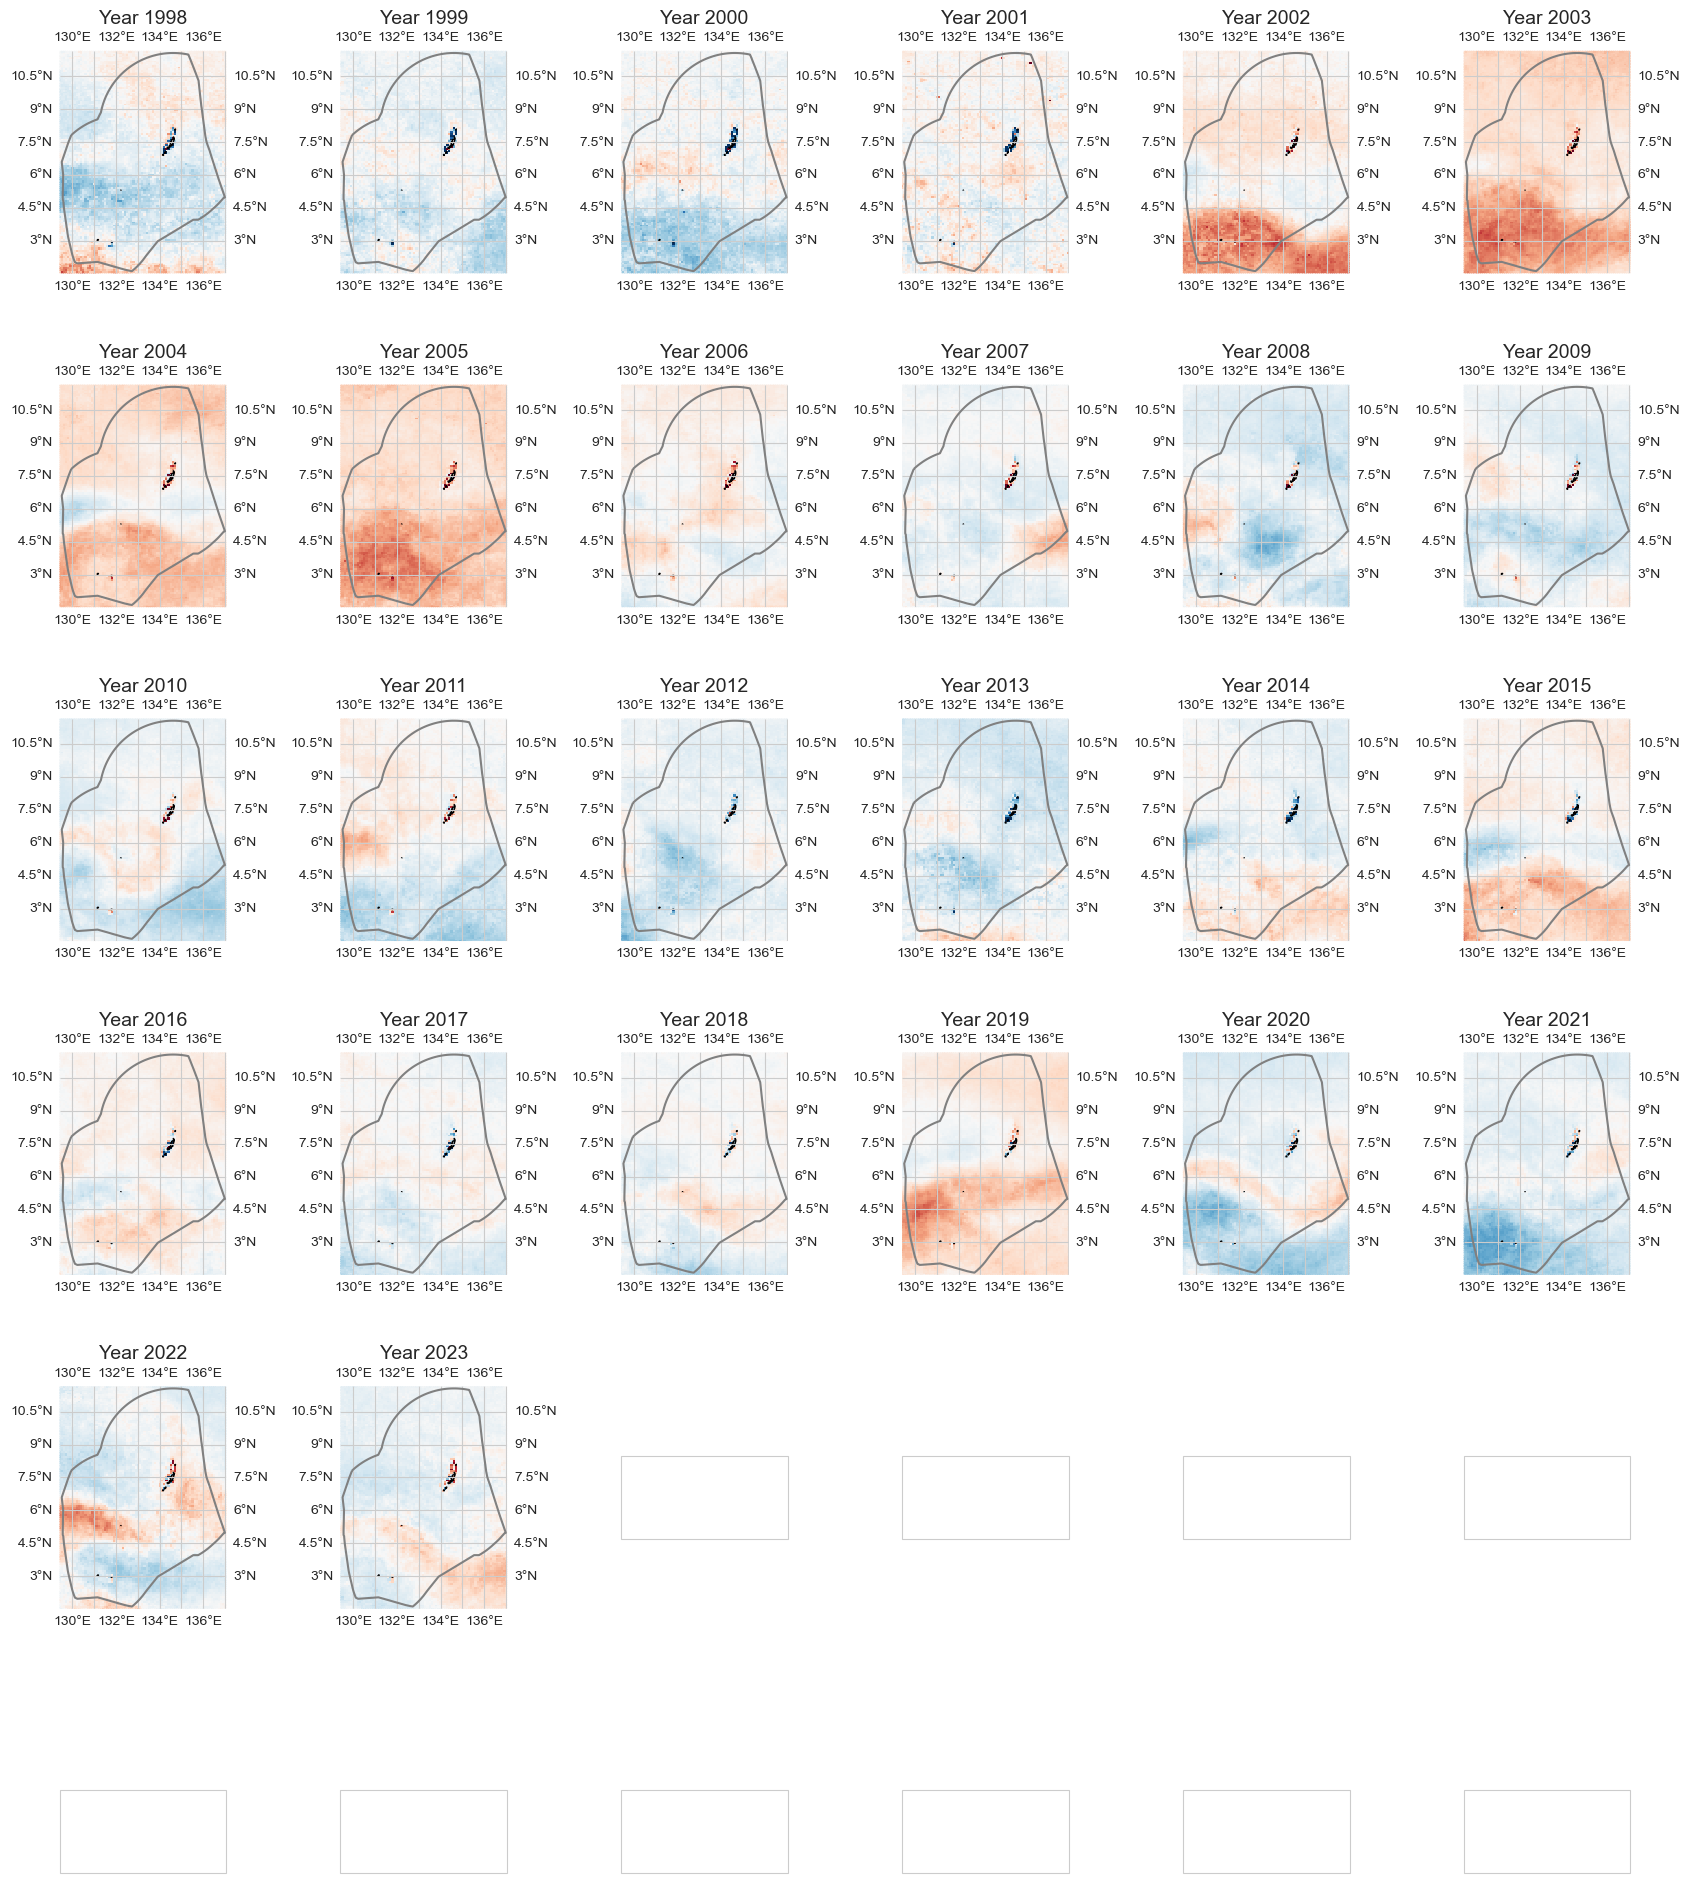

In [345]:
import matplotlib.pyplot as plt

ns = int(np.ceil(np.sqrt(len(data_y.time))))
fig, axs = plt.subplots(ns, ns, figsize=(17, 20), subplot_kw={'projection': ccrs.PlateCarree()}, )
axs = axs.flatten()
for i, y in enumerate(data_y.time.dt.year.values):

    # data_year = data_xr.isel(time=i)
    data_year = data_an.isel(time=i)
    ax = axs[i]
    if i < len(data_y.time):
        ax = plot_map(shp_eez=shp_eez, ax = ax)
        # im = ax.pcolor(data_year.longitude, data_year.latitude, data_year.MD50, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=0.4, vmax=1.6)
        im = ax.pcolor(data_year.longitude, data_year.latitude, data_year.MD50, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-.3, vmax=.3)
        ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
        ax.set_title(f'Year {y}', fontsize=fontsize)
        ax.spines['geo'].set_visible(False)
    else:
        fig.delaxes(ax)  # Remove the empty subplot

# plt.colorbar(im, ax=axs, label='Phytoplankton (µm)', orientation='horizontal')
plt.tight_layout(h_pad=0.2, w_pad=0.2)
plt.tight_layout()
plt.show()


## Mean Area

In [189]:
dict_plot = [{'data' : data_xr.mean(dim = ['longitude', 'latitude']).to_dataframe(), 
              'var' : 'MD50', 'ax' : 1, 'label' : 'Median Phytoplankton Size - MEAN AREA'},]

In [185]:
fig = plot_timeseries_interactive(dict_plot, trendline=True, scatter_dict = None);

In [188]:
loc = [7.3419, 134.4797]
dict_plot = [{'data' : data_xr.sel(longitude=loc[1], latitude=loc[0], method='nearest').to_dataframe(), 
              'var' : 'MD50', 'ax' : 1, 'label' : f'Median Phytoplankton Size at [{loc[0]}, {loc[1]}]'},]

In [187]:
fig = plot_timeseries_interactive(dict_plot, trendline=True, scatter_dict = None);